# Signals 3: Feature Engineering, PPG and Regression

## Course: Anvendt Programmering for Biomedical Engineering Students

## Primary Focus:
Feature definition, PPG physiology, linear regression, and variation metrics.

## Instructor: Martin Siemienski Andersen

# Overblik (i dag)

- Vi arbejder med PPG og **Feature**‑udtræk
- Vi går fra rå tidsserie → beats → **Feature**‑tabel
- Vi afslutter med at præsentere og fortolke resultater (variation/usikkerhed)

**Hvorfor skal vi kunne det?**
- Fordi det ofte er **Features** vi rent faktisk vil vide noget om (fx puls, variation, amplitude, rise time)
- Fordi det er sådan man gør signaler sammenlignelige og klar til statistik/ML/QA
- Fordi gode **Feature**‑mål giver et enkelt, målbart svar på et fysiologisk spørgsmål


# Etik: hvorfor gemme Features istedet for en tidsserie

## Idéen
- Rå biosignaler kan rumme mere information end nødvendigt for formålet (og kan være følsomme).
- **Feature**‑tabeller er ofte tilstrækkelige til statistik/ML/QA og kan reducere risiko ved deling og opbevaring.


## Vigtige nuancer
- **Feature** er ikke automatisk anonymisering: afledte data kan stadig være personoplysninger/helbredsoplysninger.
- Valget handler om *formål* og *nødvendighed* — og om at dokumentere hvad du har gjort.

**Referencer (GDPR, EUR‑Lex)**
- Dataminimering: art. 5(1)(c) https://eur-lex.europa.eu/eli/reg/2016/679/oj
- Formålsbegrænsning: art. 5(1)(b) https://eur-lex.europa.eu/eli/reg/2016/679/oj
- Privacy by design: art. 25 https://eur-lex.europa.eu/eli/reg/2016/679/oj
- Sikkerhed ved behandling: art. 32 https://eur-lex.europa.eu/eli/reg/2016/679/oj
- Særlige kategorier (helbredsoplysninger): art. 9 https://eur-lex.europa.eu/eli/reg/2016/679/oj

# Hvad er en Feature? (formelt)

## Definition
- En **Feature** er en funktion $f(\mathbf{x})$ der kortlægger et signal (eller et segment/beat) til et tal:
  $$f: \mathbb{R}^N \to \mathbb{R}$$
- Målet er at opsummere *relevant* information og ignorere resten (støj/irrelevant variation).

## Kvalitetskriterier (tommelregler)
- **Fortolkbar**: kan forklares fysiologisk/teknisk
- **Robust**: ændrer sig ikke voldsomt ved små artefakter/parameterændringer
- **Reproducerbar**: samme data + samme pipeline ⇒ samme tal
- **Brugbar**: hjælper på et konkret spørgsmål (QA, statistik, ML)

## Eksempler i PPG
- Amplitude (peak − baseline/foot)
- Rise time (foot → peak)
- IBI (inter-beat interval) og BPM

# Forskel på en Feature og et Filter

- Et **filter** ændrer et signal for at fremhæve/fjerne bestemte mønstre.
- En **Feature** udtrækker et *tal* (eller få tal) der opsummerer noget relevant i signalet/et beat

## Sammenligning
- **Output**: filter → signal; **Feature** → tal/vektor (Feature‑tabel)
- **Formål**: filter → støjreduktion/separation; **Feature** → måling/opsummering til statistik/ML/QA
- **Matematik**: filtre er ofte lineære/tidsinvariante (LTI); **Feature** er ofte ikke‑lineær (peak, max, threshold, logik)

## Man kan (næsten) sige: “Feature er et informations‑filter”
- En **Feature** “filtrerer information” ved at beholde det vi vil måle og ignorere resten.

## Eksempel (PPG)
- Low‑pass filter: gør pulskurven glattere → lettere peak detection
- **Feature**: amplitude, rise time, IBI/BPM → tal pr. beat der kan sammenlignes og plottes med fx error bars

# Definer det underliggende information fra en waveform


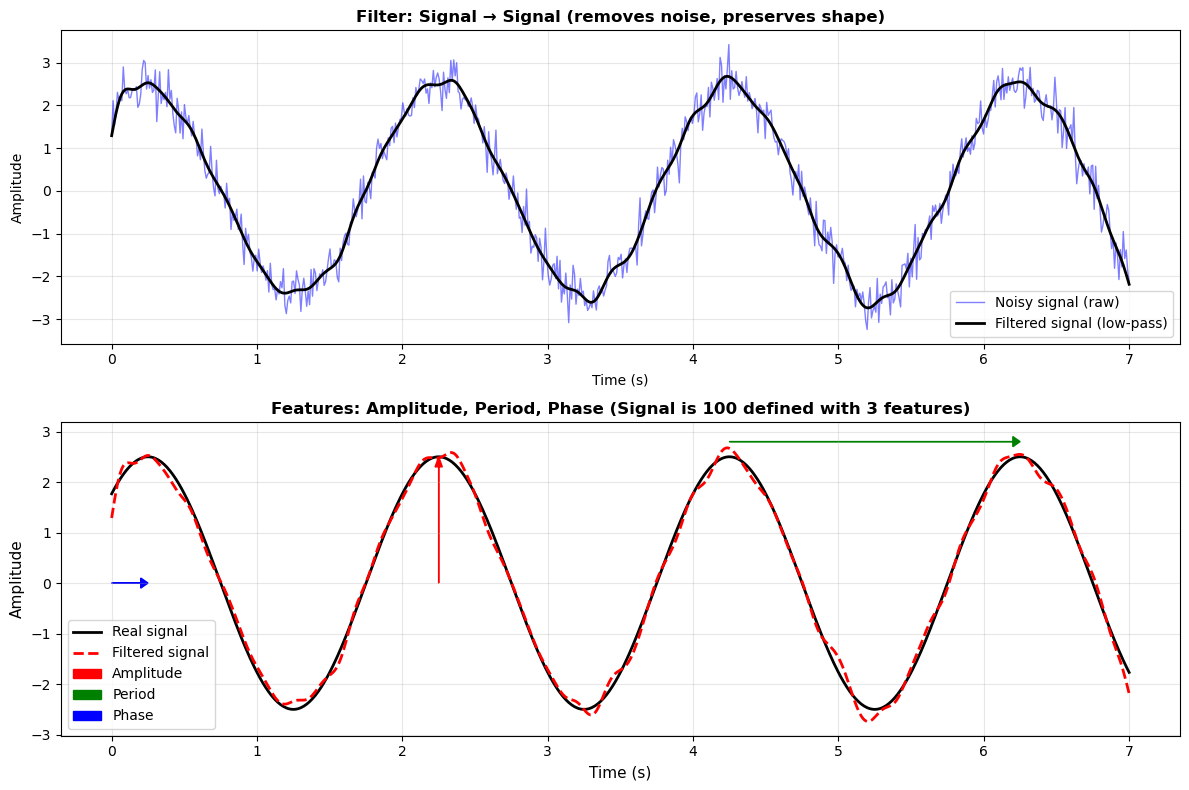

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as scipy_signal

# Generate from features: amplitude, frequency, phase
fs = 100  # sampling frequency (Hz)
time_max = 7
t = np.linspace(0, time_max, fs * time_max)  
f0 = 0.5  # frequency (Hz)
A = 2.5  # amplitude
phase = np.pi / 4  # phase offset

# Clean signal
clean_signal = A * np.sin(2 * np.pi * f0 * t + phase)
# Add noise
noise = np.random.normal(0, 0.3, len(t))
noisy_signal = clean_signal + noise
# Apply a low-pass filter (Butterworth)
b, a = scipy_signal.butter(4, 5, fs=fs, btype='low')
filtered_signal = scipy_signal.filtfilt(b, a, noisy_signal)
def peak_time(n, f0, phase):
    return (np.pi/2 - phase + n * 2*np.pi) / (2 * np.pi * f0)



# Visualization
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Top plot: Filter example
axes[0].plot(t, noisy_signal, 'blue', alpha=0.5, linewidth=1, label='Noisy signal (raw)')
axes[0].plot(t, filtered_signal, 'black', linewidth=2, label='Filtered signal (low-pass)')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Filter: Signal → Signal (removes noise, preserves shape)', fontsize=12, weight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Bottom plot: Feature extraction (improved)
axes[1].plot(t, clean_signal, 'black', linewidth=2, label='Real signal')
axes[1].plot(t, filtered_signal, 'red', linewidth=2,linestyle="--", label='Filtered signal')
axes[1].arrow(peak_time(1, f0, phase), 0, 0, A,
               head_width=0.05, head_length=0.2, fc='red', ec='red', length_includes_head=True, label='Amplitude')
axes[1].arrow(peak_time(2, f0, phase), A+0.3, (peak_time(2, f0, phase)-peak_time(1, f0, phase)), 0,
               head_width=0.2, head_length=0.05, fc='green', ec='green', length_includes_head=True, label='Period', )
axes[1].arrow(0, 0, peak_time(0, f0, phase), 0,
               head_width=0.2, head_length=0.05, fc='blue', ec='blue', length_includes_head=True, label='Phase')

axes[1].set_xlabel('Time (s)', fontsize=11)
axes[1].set_ylabel('Amplitude', fontsize=11)
axes[1].set_title('Features: Amplitude, Period, Phase (Signal is 100 defined with 3 features)', fontsize=12, weight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()


# Fra signal til Feature‑tabel

## Struktur
- Én række pr. beat (eller pr. tidsvindue)
- Kolonner = **Feature**‑mål + evt. kvalitet/flag

## Eksempel på kolonner (beat‑niveau)
*Fra sinus eksemplet:*
- `phase`
- `perioden`
- `amplituden`

*Fra SCG og EKG:*
- `RR`
- `RtoS1` (tidspunkt)
- `RtoS2` (inter-beat interval)
- `S1toS2`

![s1s2_classification](files/s1s2_classification.png)
## Hvorfor tabellen er vigtig
- Gør det nemt at lave `describe()`, plots, grupperinger og sammenligninger
- Gør det muligt at vise variation (fx pr. person eller før/efter)

# Variation og “error bars” (hvordan og hvordan man læser dem)

In [2]:
import pandas as pd
# Load the data
df_peaks = pd.read_csv('files/peaks_ECGPCG2.csv')
# Calculate timing intervals (in samples, convert to time if needed)
df_peaks['R_to_S1'] = df_peaks['S1'] - df_peaks['R']
df_peaks['R_to_S2'] = df_peaks['S2'] - df_peaks['R']
df_peaks['S1_to_S2'] = df_peaks['S2'] - df_peaks['S1']

# Calculate statistics for each interval
intervals = ['R_to_S1', 'R_to_S2', 'S1_to_S2']
means = []
stds = []
sems = []

for interval in intervals:
    data = df_peaks[interval].dropna()
    means.append(np.mean(data))
    stds.append(np.std(data))
    sems.append(np.std(data) / np.sqrt(len(data)))


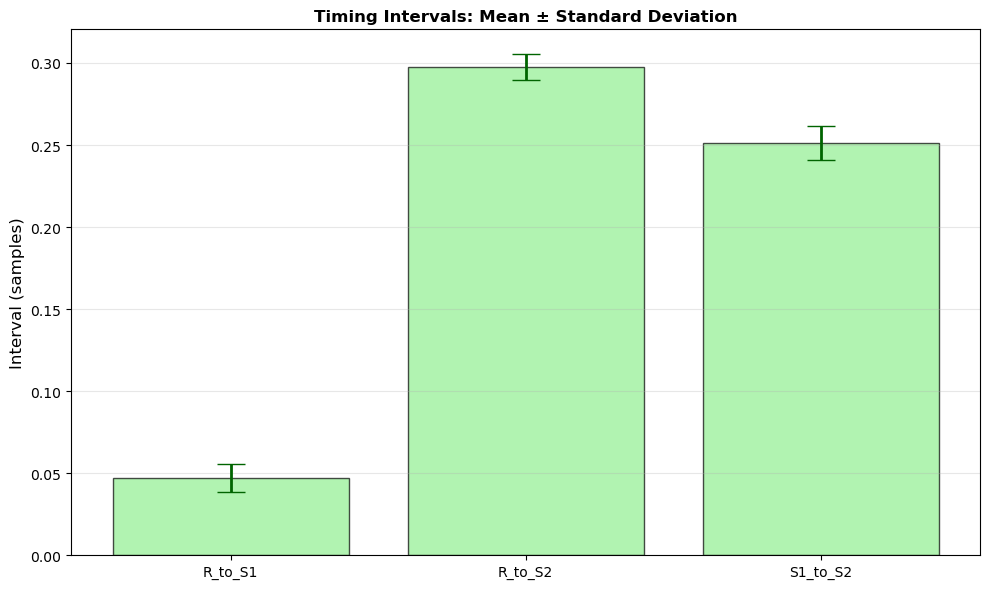

In [3]:

# Bar plot with error bars
fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(len(intervals))
ax.bar(x_pos, means, yerr=stds, capsize=10, alpha=0.7, color='lightgreen', edgecolor='black',
       error_kw={'linewidth': 2, 'ecolor': 'darkgreen'})
ax.set_xticks(x_pos)
ax.set_xticklabels(intervals)
ax.set_ylabel('Interval (samples)', fontsize=12)
ax.set_title('Timing Intervals: Mean ± Standard Deviation', fontsize=12, weight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()



## Hvad viser error bars?
- Error bars viser *variation* eller *usikkerhed* omkring et tal (typisk et gennemsnit).
- Vigtigt: man skal altid sige hvad de betyder (ellers kan de misforstås).


In [4]:
# Print statistics
print("="*70)
print("TIMING INTERVALS STATISTICS")
print("="*70)
print(f"{'Interval':<15} {'Mean':<12} {'Std Dev':<12} {'SEM':<12} {'n':<5}")
print("-"*70)
for i, interval in enumerate(intervals):
    n = len(df_peaks[interval].dropna())
    print(f"{interval:<15} {means[i]:<12.4f} {stds[i]:<12.4f} {sems[i]:<12.4f} {n:<5}")
print("="*70)
print("\nInterpretation:")
print("  Std Dev: Variability in beat-to-beat timing")
print("  SEM: Uncertainty in the mean estimate")
print("="*70)

TIMING INTERVALS STATISTICS
Interval        Mean         Std Dev      SEM          n    
----------------------------------------------------------------------
R_to_S1         0.0470       0.0085       0.0024       13   
R_to_S2         0.2975       0.0077       0.0021       14   
S1_to_S2        0.2510       0.0104       0.0029       13   

Interpretation:
  Std Dev: Variability in beat-to-beat timing
  SEM: Uncertainty in the mean estimate



## Typiske valg
- **Standardafvigelse (SD)**: spredning i dine målinger (hvor variable beats/personer er).
- **Standard error of mean (SEM)**: usikkerhed på middelværdien ($\mathrm{SEM}=\mathrm{SD}/\sqrt{n}$).
- **95% konfidensinterval (CI)**: interval for middelværdien (ofte $\bar{x} \pm 1.96\cdot \mathrm{SEM}$ ved stor $n$).

## Hvordan fortolker man det
- SD: “hvor meget varierer data?”
- SEM/CI: “hvor præcist har vi estimeret middelværdien?”
- Overlap af error bars er **ikke** en sikker test for signifikans, men kan give et hurtigt visuelt hint.


## CI

$$
CI = \frac{SEM}{\sqrt{n}}
$$


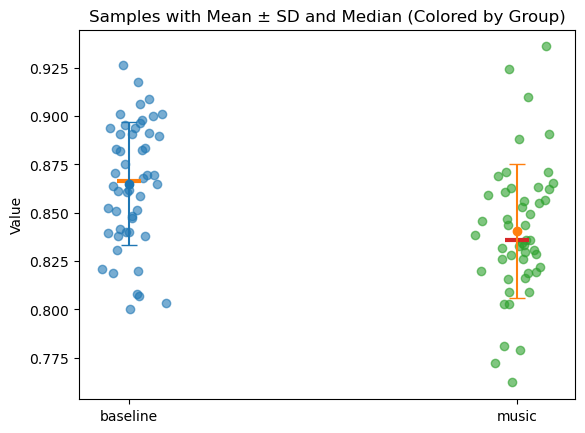

TIMING INTERVALS STATISTICS
Interval        Mean         Std Dev      SEM          CI          n    
----------------------------------------------------------------------
baseline        0.8650       0.0319       0.0045       0.0088       50   
music           0.8405       0.0348       0.0049       0.0096       50   

Interpretation:
  Std Dev: Variability in beat-to-beat timing
  SEM: Uncertainty in the mean estimate


In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Generate data from two normal distributions
data_1 = np.random.normal(loc=0.87, scale=0.03, size=50)
data_2 = np.random.normal(loc=0.84, scale=0.03, size=50)
groups = [data_1, data_2]
labels = ["baseline", "music"]

# Compute statistics
means = [g.mean() for g in groups]
medians = [np.median(g) for g in groups]
stds = [g.std(ddof=1) for g in groups]
SEMs = stds / (np.sqrt(50))
ci = SEMs * 1.96

x = np.arange(len(groups))

plt.figure()

for i, g in enumerate(groups):
    # Individual samples (with jitter)
    jitter = np.random.normal(0, 0.04, size=len(g))
    plt.scatter(
        np.full(len(g), x[i]) + jitter,
        g,
        alpha=0.6
    )

    # Mean ± SD
    plt.errorbar(
        x[i],
        means[i],
        yerr=stds[i],
        fmt='o',
        capsize=6
    )

    # Median
    plt.scatter(
        x[i],
        medians[i],
        marker='_',
        s=300,
        linewidths=3
    )

plt.xticks(x, labels)
plt.ylabel("Value")
plt.title("Samples with Mean ± SD and Median (Colored by Group)")

plt.show()

# Print statistics
print("="*70)
print("TIMING INTERVALS STATISTICS")
print("="*70)
print(f"{'Interval':<15} {'Mean':<12} {'Std Dev':<12} {'SEM':<12} {'CI':<12}{'n':<5}")
print("-"*70)
for i, (g,m,s,med,se, c) in enumerate(zip(labels,means, stds, medians, SEMs, ci)):
    print(f"{g:<15} {m:<12.4f} {s:<12.4f} {se:<12.4f} {c:<12.4f} {50:<5}")  
print("="*70)
print("\nInterpretation:")
print("  Std Dev: Variability in beat-to-beat timing")
print("  SEM: Uncertainty in the mean estimate")
print("="*70)


# Data Schema and Metadata

## Why Documentation Matters

Good data science requires reproducibility. Anyone (including future you) should be able to:
1. Understand what each column means
2. Reproduce the analysis
3. Verify results
4. Build upon the work

## Column Naming Best Practices

**Be descriptive and consistent:**
- Include units: `ibi_s` (seconds), `hr_bpm` (beats per minute), `amp_mV` (millivolts)
- Use prefixes: `mean_hr`, `std_hr`, `max_hr`
- Avoid ambiguity: `time` vs `time_s` vs `timestamp_unix`

## Metadata Requirements

Essential metadata to include:
- **Sampling frequency (fs):** Hz
- **Filter parameters:** type, cutoff, order
- **Analysis date:** (YYYY-MM-DD)
- **Software versions:** Python, NumPy, SciPy, pandas
- **Analyst:** who performed analysis
- **Data source:** device, protocol, study

# Comparing Multiple Features with Bar Plots and Error Bars

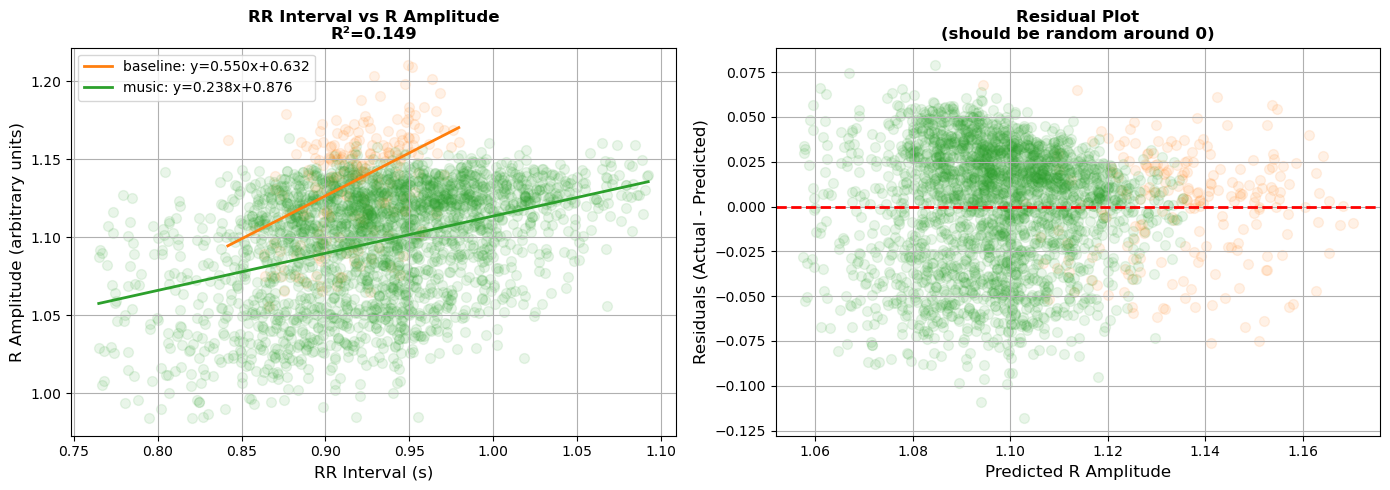


Regression Results:
  R² value:  0.1488
  p-value:   0.000000
  Slope:     0.2379

Residuals:
  Mean:      0.000000  (should be close to 0)
  Std Dev:   0.0338

Interpretation: Weak relationship


# Example 4: Real Data - RR Interval vs R Amplitude with Residuals

Does the heart rate (RR interval) affect the R-wave amplitude in ECG?

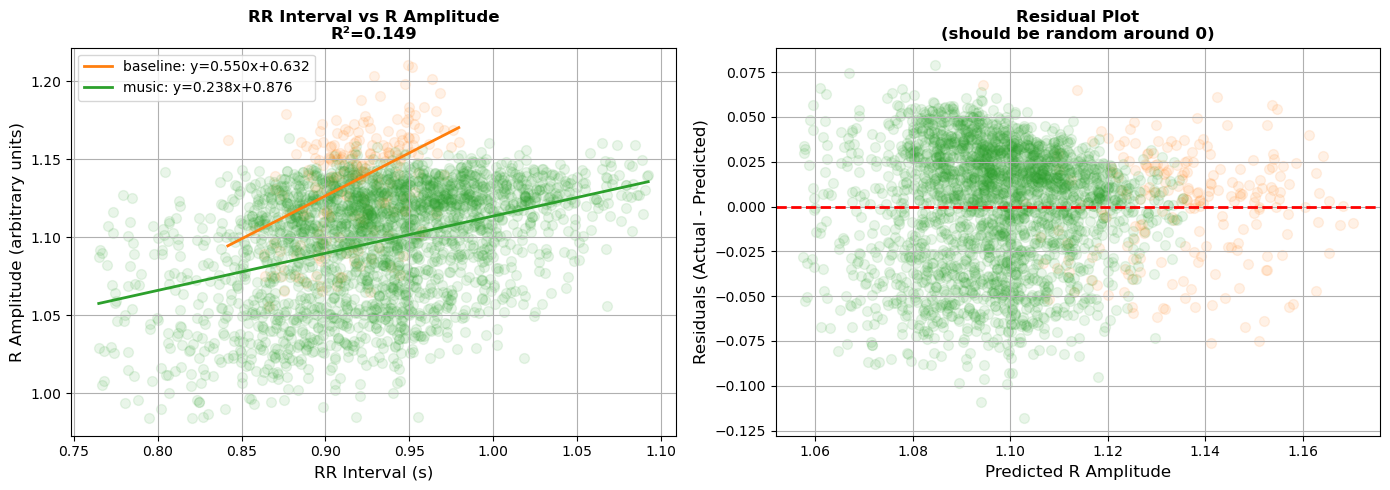


Regression Results:
  R² value:  0.1488
  p-value:   0.000000
  Slope:     0.2379

Residuals:
  Mean:      0.000000  (should be close to 0)
  Std Dev:   0.0338

Interpretation: Weak relationship


In [55]:
from scipy import stats
# Select features


# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
for label,df in dict(baseline=df_b.copy(), music=df_m.copy()).items():
    if label=="baseline":
        col = "C1"
    else:
        col = "C2"
    mask = (~df['RR'].isna()) & (~df['R_amp'].isna())
    x2 = df.loc[mask, 'RR'].values
    y2 = df.loc[mask, 'R_amp'].values


    # Perform linear regression
    slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(x2, y2)
    r_squared2 = r_value2**2

    # Create regression line
    x2_line = np.linspace(x2.min(), x2.max(), 100)
    y2_line = slope2 * x2_line + intercept2

    # Calculate residuals
    y2_pred = slope2 * x2 + intercept2
    residuals = y2 - y2_pred


    # Left plot: Scatter with regression line
    ax1.scatter(x2, y2, alpha=0.1, s=50, color=col)
    ax1.plot(x2_line, y2_line, color=col, linewidth=2, label=f'{label}: y={slope2:.3f}x+{intercept2:.3f}')
    

    # Right plot: Residuals
    ax2.scatter(y2_pred, residuals, color=col, alpha=0.1, s=50)
    
ax1.set_xlabel('RR Interval (s)', fontsize=12)
ax1.set_ylabel('R Amplitude (arbitrary units)', fontsize=12)
ax1.set_title(f'RR Interval vs R Amplitude\nR²={r_squared2:.3f}', fontsize=12, weight='bold')
ax1.legend()
ax1.grid(True)

ax2.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax2.set_xlabel('Predicted R Amplitude', fontsize=12)
ax2.set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
ax2.set_title('Residual Plot\n(should be random around 0)', fontsize=12, weight='bold')
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"\nRegression Results:")
print(f"  R² value:  {r_squared2:.4f}")
print(f"  p-value:   {p_value2:.6f}")
print(f"  Slope:     {slope2:.4f}")
print(f"\nResiduals:")
print(f"  Mean:      {np.mean(residuals):.6f}  (should be close to 0)")
print(f"  Std Dev:   {np.std(residuals):.4f}")
print(f"\nInterpretation: {'Strong' if r_squared2 > 0.7 else 'Moderate' if r_squared2 > 0.3 else 'Weak'} relationship")

# Example 3: Real Data - S1 vs S2 Amplitude

Let's investigate if there's a relationship between S1 (first heart sound) amplitude and S2 (second heart sound) amplitude.

In [ ]:
# Calculate statistics for key features
features_of_interest = ['R_amp', 'S1_amp', 'S2_amp', 'RR']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, feature in enumerate(features_of_interest):
    data = df_clean[feature]
    
    # Calculate statistics
    mean_val = np.mean(data)
    std_val = np.std(data)
    sem_val = std_val / np.sqrt(len(data))  # Standard Error of Mean
    
    # Plot histogram
    axes[i].hist(data, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
    axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.3f}')
    axes[i].axvline(mean_val - std_val, color='orange', linestyle=':', linewidth=1.5, label=f'±1 SD')
    axes[i].axvline(mean_val + std_val, color='orange', linestyle=':', linewidth=1.5)
    
    axes[i].set_xlabel(feature, fontsize=11)
    axes[i].set_ylabel('Count', fontsize=11)
    axes[i].set_title(f'{feature}: μ={mean_val:.3f}, σ={std_val:.3f}, SEM={sem_val:.3f}', fontsize=10)
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print(f"- SD (Standard Deviation) shows how much the measurements vary")
print(f"- SEM (Standard Error of Mean) shows uncertainty in our estimate of the mean")
print(f"- Smaller SEM = more confident in the mean value")

# Visualizing Features with Error Bars

Let's visualize the distribution of key features and show their variation.

In [ ]:
# Load the feature table
df = pd.read_csv('files/features_table.csv')

# Display first few rows
print("First 5 rows:")
print(df.head())
print("\n" + "="*60 + "\n")

# Summary statistics
print("Summary statistics:")
print(df.describe())
print("\n" + "="*60 + "\n")

# Check for missing values
print("Missing values per column:")
print(df.isna().sum())
print("\n" + "="*60 + "\n")

# Remove rows with missing values for cleaner analysis
df_clean = df.dropna()
print(f"Clean dataset: {len(df_clean)} beats (removed {len(df) - len(df_clean)} with missing values)")

# Example 2: Real Data - Load Feature Table

Now let's work with real extracted features from ECG and PCG signals.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data
n_samples = 50
x1 = np.linspace(0, 10, n_samples)  # Feature 1: evenly spaced from 0 to 10

# True relationship: x2 = 2*x1 + 3 + noise
true_slope = 2.0
true_intercept = 3.0
noise_std = 1.5

x2 = true_slope * x1 + true_intercept + np.random.normal(0, noise_std, n_samples)

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x1, x2)
r_squared = r_value**2

# Create regression line
x1_line = np.linspace(x1.min(), x1.max(), 100)
x2_line = slope * x1_line + intercept
x2_true = true_slope * x1_line + true_intercept

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(x1, x2, alpha=0.6, s=50, edgecolor='black', label='Data points (with noise)')
plt.plot(x1_line, x2_line, 'r-', linewidth=2, label=f'Fitted line: y={slope:.2f}x+{intercept:.2f}')
plt.plot(x1_line, x2_true, 'g--', linewidth=2, label=f'True line: y={true_slope}x+{true_intercept}')

plt.xlabel('Feature x1', fontsize=12)
plt.ylabel('Feature x2', fontsize=12)
plt.title(f'Synthetic Linear Regression\nR²={r_squared:.3f}, p={p_value:.4f}', fontsize=13, weight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print results
print("="*60)
print("SYNTHETIC DATA LINEAR REGRESSION")
print("="*60)
print(f"\nTrue relationship:  x2 = {true_slope}*x1 + {true_intercept}")
print(f"Fitted relationship: x2 = {slope:.3f}*x1 + {intercept:.3f}")
print(f"\nR² value:     {r_squared:.4f}  - {r_squared*100:.1f}% of variance explained")
print(f"p-value:      {p_value:.6f}  - {'Highly significant' if p_value < 0.001 else 'Significant' if p_value < 0.05 else 'Not significant'}")
print(f"Slope error:  {abs(slope - true_slope):.3f}  (difference from true slope)")
print(f"Intercept error: {abs(intercept - true_intercept):.3f}  (difference from true intercept)")
print(f"\n✓ The fitted line closely matches the true relationship despite noise!")
print("="*60)

# Example 1: Synthetic Data with Linear Relationship

Let's start with 100% synthetic data to understand linear regression.

We'll create two features `x1` and `x2` where `x2 = 2*x1 + 3 + noise`

# Linear Regression: Understanding Relationships

## What is Linear Regression?

**Linear regression** finds the best-fitting straight line through data points to model the relationship between two variables.

### Equation:
$$y = mx + b$$

Where:
- $y$ is the dependent variable (what we're predicting)
- $x$ is the independent variable (what we use to predict)
- $m$ is the slope (rate of change)
- $b$ is the intercept (baseline value when x=0)

### Evaluation Metrics:
- **R² (coefficient of determination):** 
  - Range: 0 to 1
  - 0 = no linear relationship
  - 1 = perfect linear relationship
- **Residuals:** differences between actual and predicted values (should be random)

### Important Note:
**Correlation ≠ Causation**
- Just because two variables are related doesn't mean one causes the other
- Consider confounding variables and alternative explanations

# Introduction to pandas DataFrames

## Why pandas for feature tables?

- **Structured data:** rows = beats/samples, columns = features
- **Named columns:** clear semantics (`amplitude_au`, `ibi_s`, `bpm`)
- **Built-in analysis:** `.describe()`, `.groupby()`, `.plot()`
- **Easy I/O:** `.to_csv()`, `.read_csv()`
- **Missing data handling:** `.isna()`, `.dropna()`, `.fillna()`

## Creating a DataFrame

```python
import pandas as pd

# From dictionary of lists
data = {
    'beat_id': [1, 2, 3],
    'amplitude': [2.5, 2.7, 2.4],
    'ibi_s': [0.85, 0.87, 0.83]
}
df = pd.DataFrame(data)
```

## Essential operations
- `df.head()` - first 5 rows
- `df.describe()` - summary statistics
- `df['column']` - select column
- `df[df['amplitude'] > 2.0]` - filter rows
- `df.to_csv('features.csv', index=False)` - save

# Feature Extraction Pipeline

## The complete workflow:

1. **Load and inspect:** check units, sampling frequency (fs), missing values
2. **Filter/smooth:** optional preprocessing to improve peak detection
3. **Segment into beats:** find pulse onsets (foot) and peaks
4. **Compute features per beat:** amplitude, rise time, intervals
5. **Quality control:** flag bad beats (low amplitude, irregular, artifacts)
6. **Aggregate:** build feature table (one row per beat)
7. **Save with metadata:** enable reproducibility

This pipeline ensures:
- Consistent feature extraction
- Reproducible results
- Quality data for analysis

# Feature Types

Different categories of features for signal analysis:

## Beat-level features:
- **Amplitude:** peak - foot (pulse pressure indicator)
- **Rise time:** time from foot → peak (contractility)
- **Width:** pulse duration
- **Area under curve:** integrated flow

## Interval-level features:
- **IBI (Inter-Beat Interval):** time between consecutive beats
- **Heart Rate:** 60 / IBI (in seconds) = bpm
- **RR interval:** if using ECG reference

## Aggregated features:
- **Mean HR:** average heart rate over period
- **HRV (Heart Rate Variability):** variability in IBIs
- **Artifact percentage:** quality metric

## Contextual features:
- Depend on state: posture, activity, time of day

## Derived features:
- Combine other features: contractility index, perfusion index

# PPG Physiology

## What is PPG?
**Photoplethysmography (PPG)** measures changes in blood volume using light absorption.

## How it works:
- Light (typically red or infrared) shines through skin
- Blood absorbs light differently than surrounding tissue
- When heart beats → more blood → more absorption → signal changes
- Sensor detects reflected or transmitted light

## Why PPG?
- **Portable:** fingertip, wrist, ear
- **Non-invasive:** no needles, no pain
- **Easy to measure:** simple sensor, widely available in wearables
- **Rich information:** heart rate, rhythm, blood flow patterns

## Pulse Landmarks
- **Foot:** pulse start (systolic rise beginning)
- **Systolic peak:** maximum (highest blood volume during systole)
- **Dicrotic notch:** secondary peak (aortic valve closure, marks end of systole)

## Signal Properties
PPG signals vary with:
- Perfusion (blood flow to tissue)
- Arterial pressure and compliance
- Motion artifacts (movement)
- Sensor contact quality
- Ambient light interference

# Exercises

## Exercise 1: Explore Respiratory Features
Using the feature table:
1. Calculate mean, SD, and SEM for `Resp_mean` and `Resp_std`
2. Create a scatter plot showing the relationship between them
3. Perform linear regression and interpret the R² value

## Exercise 2: Time Interval Analysis
1. Create a new column `HR_bpm` calculated from `RR` interval (HR = 60/RR)
2. Plot HR over time (beat number on x-axis, HR on y-axis)
3. Calculate and display mean HR ± SD
4. Identify any outliers (beats where HR deviates > 2 SD from mean)

## Exercise 3: Feature Comparison
1. Create a correlation matrix for all timing features (`RtoT`, `RtoS1`, `RtoS2`, `S1toS2`)
2. Use `df.corr()` to compute correlations
3. Visualize using a heatmap (optional: use `seaborn.heatmap`)
4. Which features are most strongly correlated?

## Exercise 4: Quality Control
1. Define "bad beats" as those where `S1_amp < 4.5` OR `S2_amp < 3.5`
2. Create a boolean column `is_good_beat` indicating quality
3. Calculate percentage of good beats
4. Compare mean features for good vs bad beats

## Exercise 5: Save Your Analysis
1. Create your own metadata dictionary with:
   - Your name as analyst
   - Today's date
   - Description of what you analyzed
   - Key findings (means, correlations, etc.)
2. Save both results and metadata to files
3. Verify you can reload and reproduce your analysis

# Summary: Key Takeaways

## What We Learned

### 1. Features
- **Definition:** Function that maps signal/beat → number(s)
- **Purpose:** Summarize relevant information, ignore noise
- **Quality:** Interpretable, robust, reproducible, useful

### 2. Feature vs Filter
- **Filter:** signal → signal (removes noise, preserves shape)
- **Feature:** signal → number (summarizes to table)

### 3. PPG Physiology
- Non-invasive optical measurement of blood volume
- Key landmarks: foot, systolic peak, dicrotic notch
- Applications: heart rate, rhythm, perfusion monitoring

### 4. Feature Extraction Pipeline
1. Load → 2. Filter → 3. Segment → 4. Compute → 5. QC → 6. Aggregate → 7. Save

### 5. pandas DataFrames
- Structured tables: rows = observations, columns = features
- Built-in analysis: `.describe()`, `.groupby()`, `.plot()`
- Easy I/O: `.to_csv()`, `.read_csv()`

### 6. Linear Regression
- Model relationships: y = mx + b
- Evaluate with R² (goodness of fit) and residuals
- Start with synthetic data to understand the method
- Then apply to real data
- **Remember:** Correlation ≠ Causation

### 7. Variation Metrics
- **SD (Standard Deviation):** Data spread/variability
- **SEM (Standard Error):** Uncertainty in mean estimate (SD/√n)
- **95% CI:** Plausible range for true mean
- Always explain what error bars represent!

### 8. Documentation
- Clear column names with units
- Metadata: fs, filters, dates, analyst, software versions
- Reproducibility: document everything needed to replicate

## Ethics Reminder
- Features reduce but don't eliminate privacy concerns
- Store only necessary data (data minimization)
- Document processing (transparency)
- Obtain proper consent for data use